# Helpers

In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

In [5]:
csv_dir = "../output/"

In [6]:
def parse_boundary(csv_path):
    data = pd.read_csv(csv_path, header=None)
    x, y, z = data[0], data[1], data[2]
    # x, y = (x + 1) / 2, (y + 1) / 2
    return x, y, z

In [7]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

def parse_csv_for_xy(path):
    # Read CSV assuming pairs of x, y coordinates (x1, y1, x2, y2, ...)
    data = pd.read_csv(path, header=None)
    
    # Convert all values to numeric, forcing errors to NaN (which makes them easier to handle)
    data = data.apply(pd.to_numeric, errors='coerce')

    # Flatten the data into x and y arrays
    x_vals = data.iloc[:, 0::2].values.flatten()  # Extract x values (every other column starting from 0)
    y_vals = data.iloc[:, 1::2].values.flatten()  # Extract y values (every other column starting from 1)

    return x_vals, y_vals

def get_original_points(s = 16):
    x = []
    y = []
    for j in range(s):
        for i in range(s):
            x.append((i / (s - 1)) * 2 - 1)
            y.append((j / (s - 1)) * 2 - 1)
    x = np.array(x)
    y = np.array(y)
    x = np.clip(x, 0, 1)
    y = np.clip(y, 0, 1)
    return x, y
        

def visualize_csv_output_vector(path, output_path="./solver_output_plot.png", original_point=None, xstart=0, ystart=0, xend=1, yend=1, surface=False):
    # Parse CSV to get x, y values
    x_vals, y_vals = parse_csv_for_xy(path)
    
    # Remove NaN values from the data
    valid_mask = ~np.isnan(x_vals) & ~np.isnan(y_vals)  # Create mask for non-NaN values in x and y
    x_vals = x_vals[valid_mask]  
    y_vals = y_vals[valid_mask] 
    
    assert len(x_vals) == len(y_vals), "x_vals and y_vals must have the same length"
    z_vals = np.zeros_like(x_vals)
    
    x = np.linspace(xstart, xend, 100)  # Increase resolution if necessary
    y = np.linspace(ystart, yend, 100)  # Increase resolution if necessary
    X, Y = np.meshgrid(x, y)
    
    # Interpolate the Z values onto the grid (if you want smooth surface interpolation)
    Z_interp = griddata((x_vals, y_vals), z_vals, (X, Y), method='linear')

    # Create a figure for plotting
    fig = go.Figure()

    # Add surface plot with interpolated Z values (if surface is true)
    if surface: 
        fig.add_trace(go.Surface(z=Z_interp, x=X, y=Y, colorscale='Viridis', showscale=True))

    # Add a scatter plot for the original points (if surface is false)
    if not surface:
        fig.add_trace(go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='markers',
            marker=dict(size=2, color='blue') 
        ))
        
    
    # Add boundary if provided
    if original_point is not None: 
        x_original, y_original = get_original_points()
        z_original = np.zeros_like(x_original) - 0.001
        fig.add_trace(go.Scatter3d(x=x_original, y=y_original, z=z_original, mode='markers',
            marker=dict(size=2, color='red')  
        ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        zaxis=dict(
            range=[-0.01, 0.01]  # Set the Z-axis range (adjust these values as needed)
        ),
        aspectmode='cube'  # Ensures that all axes are scaled equally
    ))

    # Show the plot and save to file
    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")

In [8]:
import plotly.graph_objects as go
def print_boundary_dirichlet(path=None, shape=None, dir=None): 
    if path is None: path = dir + shape + 'BoundaryDirichlet.csv'
    x, y, z = parse_boundary(path)
    fig = go.Figure()
    for i in range(len(x)):
        fig.add_trace(go.Scatter3d(
            x=[x[i], x[(i + 1) % len(x)]],
            y=[y[i], y[(i + 1) % len(y)]],
            z=[z[i], z[(i + 1) % len(z)]],
            mode='lines',
            line=dict(color='blue', width=2)
        ))
    fig.add_trace(go.Scatter3d(x=x,y=y,z=z,mode='markers',
        marker=dict(size=5, color='red', opacity=0.8)  # Color points
    ))

    fig.update_layout(title_text='3D Star Shape on a Tilted Plane',
                  scene=dict(
                      xaxis_title='X-axis',
                      yaxis_title='Y-axis',
                      zaxis_title='Z-axis'),
                  )

    fig.show()

In [9]:
def get_shape_csv(shape): 
    return shape + ".csv"
def get_boundaryD_csv(shape): 
    return shape + "BoundaryDirichlet.csv"

# Plot Deformed Rectangle

In [202]:
shape = "rectangle_displacement"
shape_csv = get_shape_csv(shape)
boundary_csv = get_boundaryD_csv(shape)

In [203]:
print_boundary_dirichlet(path=csv_dir + boundary_csv) 

In [206]:
visualize_csv_output_vector(csv_dir + shape_csv, original_point=True) 

Figure saved as ./solver_output_plot.png


In [10]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

def parse_csv_for_xy(path):
    # Read CSV assuming pairs of x, y coordinates (x1, y1, x2, y2, ...)
    data = pd.read_csv(path, header=None)
    
    # Convert all values to numeric, forcing errors to NaN (which makes them easier to handle)
    data = data.apply(pd.to_numeric, errors='coerce')

    # Flatten the data into x and y arrays
    x_vals = data.iloc[:, 0::2].values.flatten()  # Extract x values (every other column starting from 0)
    y_vals = data.iloc[:, 1::2].values.flatten()  # Extract y values (every other column starting from 1)

    return x_vals, y_vals

def get_original_points(s=16):
    x = []
    y = []
    for j in range(s):
        for i in range(s):
            x.append((i / (s - 1)) * 2 - 1)
            y.append((j / (s - 1)) * 2 - 1)
    x = np.array(x)
    y = np.array(y)
    x = np.clip(x, 0, 1)
    y = np.clip(y, 0, 1)
    return x, y

def visualize_displacement_with_arrows(path, output_path="./displacement_vector_field.png", s=16):
    # Parse CSV to get x, y values after deformation
    x_vals_deformed, y_vals_deformed = parse_csv_for_xy(path)
    
    # Get original points in the elastic material
    x_original, y_original = get_original_points(s)
    
    # Ensure lengths match between original and deformed points
    assert len(x_original) == len(x_vals_deformed), "Original and deformed points must have the same length."
    assert len(y_original) == len(y_vals_deformed), "Original and deformed points must have the same length."

    # Create a figure for plotting
    fig = go.Figure()

    # Add a vector field plot to represent displacement
    for x0, y0, x1, y1 in zip(x_original, y_original, x_vals_deformed, y_vals_deformed):
        fig.add_trace(go.Scatter3d(
            x=[x0, x1],  # Line starts at original point and ends at deformed point
            y=[y0, y1],
            z=[0, 0],  # Assuming displacement in 2D plane, set Z to 0
            mode='lines+markers',
            marker=dict(size=2, color='blue'),
            line=dict(color='green', width=2)
        ))
    
    # Add layout adjustments
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ))

    # Show the plot and save to file
    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")


In [210]:
visualize_displacement_with_arrows(csv_dir + shape_csv, output_path=csv_dir + "displacement_vector_field.png")

Figure saved as ../output/displacement_vector_field.png


In [211]:
def visualize_deformed_grid(path, output_path="./deformed_grid.png", s=16):
    # Parse CSV to get x, y values after deformation
    x_vals_deformed, y_vals_deformed = parse_csv_for_xy(path)
    
    # Get original points in the elastic material
    x_original, y_original = get_original_points(s)
    
    # Create a figure for plotting
    fig = go.Figure()

    # Plot the original grid points
    fig.add_trace(go.Scatter3d(
        x=x_original,
        y=y_original,
        z=np.zeros_like(x_original),
        mode='markers',
        marker=dict(size=3, color='red', symbol='circle'),
        name='Original Grid'
    ))

    # Plot the deformed grid points
    fig.add_trace(go.Scatter3d(
        x=x_vals_deformed,
        y=y_vals_deformed,
        z=np.zeros_like(x_vals_deformed),
        mode='markers',
        marker=dict(size=3, color='blue', symbol='circle'),
        name='Deformed Grid'
    ))

    # Update layout for better visualization
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ))

    # Show the plot and save to file
    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")


In [212]:
visualize_deformed_grid(csv_dir + shape_csv, output_path=csv_dir + "deformed_grid.png")

Figure saved as ../output/deformed_grid.png


In [11]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib import cm

def parse_csv_for_xy(path):
    # Read CSV assuming pairs of x, y coordinates (x1, y1, x2, y2, ...)
    data = pd.read_csv(path, header=None)
    
    # Convert all values to numeric, forcing errors to NaN (which makes them easier to handle)
    data = data.apply(pd.to_numeric, errors='coerce')

    # Flatten the data into x and y arrays
    x_vals = data.iloc[:, 0::2].values.flatten()  # Extract x values (every other column starting from 0)
    y_vals = data.iloc[:, 1::2].values.flatten()  # Extract y values (every other column starting from 1)

    return x_vals, y_vals

def get_original_points(s=16):
    x = []
    y = []
    for j in range(s):
        for i in range(s):
            x.append((i / (s - 1)) * 2 - 1)
            y.append((j / (s - 1)) * 2 - 1)
    x = np.array(x)
    y = np.array(y)
    x = np.clip(x, 0, 1)
    y = np.clip(y, 0, 1)
    return x, y

def visualize_displacement_with_arrows(path, output_path="./displacement_vector_field.png", s=16):
    # Parse CSV to get x, y values after deformation
    x_vals_deformed, y_vals_deformed = parse_csv_for_xy(path)
    
    # Get original points in the elastic material
    x_original, y_original = get_original_points(s)
    
    # Ensure lengths match between original and deformed points
    assert len(x_original) == len(x_vals_deformed), "Original and deformed points must have the same length."
    assert len(y_original) == len(y_vals_deformed), "Original and deformed points must have the same length."

    # Number of unique colors needed, based on columns
    num_colors = s
    colors = cm.rainbow(np.linspace(0, 1, num_colors))  # Use a colormap to generate unique colors

    # Create a figure for plotting
    fig = go.Figure()

    # Add a vector field plot to represent displacement, color-coded by column
    for idx, (x0, y0, x1, y1) in enumerate(zip(x_original, y_original, x_vals_deformed, y_vals_deformed)):
        col_index = idx % s  # Determine the column index (0 to s-1)
        color = 'rgb({}, {}, {})'.format(*[int(255 * c) for c in colors[col_index][:3]])  # Convert color to RGB
        
        # Add an arrow from the original point to the deformed point
        fig.add_trace(go.Scatter3d(
            x=[x0, x1],  # Line starts at original point and ends at deformed point
            y=[y0, y1],
            z=[0, 0],  # Assuming displacement in 2D plane, set Z to 0
            mode='lines+markers',
            marker=dict(size=2, color=color),
            line=dict(color=color, width=2)
        ))
    
    # Add layout adjustments
    fig.update_layout(scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube'
    ))

    # Show the plot and save to file
    fig.show()
    fig.write_image(output_path)
    print(f"Figure saved as {output_path}")

# Example usage
visualize_displacement_with_arrows(csv_dir + shape_csv, output_path=csv_dir + "displacement_vector_field.png")


NameError: name 'shape_csv' is not defined

### Stress Visualizer 

In [12]:
import autograd.numpy as np
from autograd import jacobian

def calculate_individual_displacement_gradient_2D(original_points, deformed_points):
    assert len(original_points) == len(deformed_points)
    displacements = deformed_points - original_points
    dx = original_points[1, 0] - original_points[0, 0]
    dy = original_points[1, 1] - original_points[0, 1] # spacing between points is too big 
    # each point should have value and derivatives delta_x and delta_y 

    if dx == 0 or dy == 0:
        raise ValueError("Finite difference requires non-zero changes in x and y.")
    dudx = (displacements[1, 0] - displacements[0, 0]) / dx  # ∂u_x/∂x
    dudy = (displacements[1, 0] - displacements[0, 0]) / dy  # ∂u_x/∂y
    dvdx = (displacements[1, 1] - displacements[0, 1]) / dx  # ∂u_y/∂x
    dvdy = (displacements[1, 1] - displacements[0, 1]) / dy  # ∂u_y/∂y
    gradient = np.array([[dudx, dudy],
                         [dvdx, dvdy]])
    return gradient

def calculate_displacement_gradient_2D(original_points, deformed_points):
    assert len(original_points) == len(deformed_points)
    gradients = np.zeros((len(original_points) - 1, 2, 2))
    for i in range(len(original_points) - 1):
        gradients[i] = calculate_individual_displacement_gradient_2D(original_points[i:i+2], deformed_points[i:i+2])
    return gradients

def calculate_individual_strain_2D(displacement_gradient):
    return 0.5 * (displacement_gradient + displacement_gradient.T )

def calculate_strain_2D(original_points, deformed_points):
    assert len(original_points) == len(deformed_points)
    strain = np.zeros((len(original_points) - 1, 2, 2))
    for i in range(len(original_points) - 1):
        strain[i] = calculate_individual_strain_2D(calculate_individual_displacement_gradient_2D(original_points[i:i+2], deformed_points[i:i+2]))
    return strain 

## linear elasticity 
## 2D isotropic materia
def calculate_individual_stress_2D(strain, lam, mu):
    return lam * np.trace(strain) * np.eye(strain.shape[0]) + 2 * mu * strain

def calculate_stress_2D(original_points, deformed_points, lam, mu):
    assert len(original_points) == len(deformed_points)
    stress = np.zeros((len(original_points) - 1, 2, 2))
    for i in range(len(original_points) - 1):
        displacement_gradient = calculate_individual_displacement_gradient_2D(original_points[i:i+2], deformed_points[i:i+2])
        strain = calculate_individual_strain_2D(displacement_gradient)
        stress[i] = calculate_individual_stress_2D(strain, lam, mu)
    return stress
    
def calculate_traction(stress, normal):
    return np.dot(stress, normal)

In [13]:
deformed_x, deformed_y = parse_csv_for_xy(csv_dir + shape_csv)
original_x, original_y = get_original_points(s = 16)
deformed_points = np.dstack((deformed_x, deformed_y))  # Shape: (N, 1, 2)
original_points = np.dstack((original_x, original_y))  # Shape: (N, 1, 2)
valid_mask = ~np.isnan(deformed_x) & ~np.isnan(deformed_y) & ~np.isnan(original_x) & ~np.isnan(original_y)

deformed_points = np.column_stack((deformed_x, deformed_y))  # Shape: (N, 2)
original_points = np.column_stack((original_x, original_y))  # Shape: (N, 2)

# Create a valid mask to filter out NaN values
valid_mask = ~np.isnan(deformed_x) & ~np.isnan(deformed_y) & ~np.isnan(original_x) & ~np.isnan(original_y)

deformed_points = deformed_points[valid_mask]
original_points = original_points[valid_mask]


NameError: name 'shape_csv' is not defined

### Strain from CSV

In [16]:
def extract_gradient_2D(path):
    data = pd.read_csv(path, header=None)
    data = data.apply(pd.to_numeric, errors='coerce')
    data.dropna(inplace=True)
    x, y = data.iloc[:, 0].values.flatten(), data.iloc[:, 1].values.flatten()
    dudx, dudy, dvdx, dvdy = data.iloc[:, 2].values.flatten(), data.iloc[:, 3].values.flatten(), data.iloc[:, 4].values.flatten(), data.iloc[:, 5].values.flatten()
    coordinates = np.stack((x, y), axis=1)
    gradient_matrices = []
    for i in range(len(coordinates)):
        gradient_matrix = np.array([[dudx[i], dudy[i]], [dvdx[i], dvdy[i]]])
        gradient_matrices.append(gradient_matrix)
    return coordinates, np.array(gradient_matrices)

In [15]:

strain_csv_path = "../solver/deformation_gradient_rect.csv"
coordinates, gradients = extract_gradient_2D(strain_csv_path)

In [17]:
strain_csv_path_01 = "../solver/deformation_gradient_crackPropagation_0.1.csv"
coordinates_01, gradients_01 = extract_gradient_2D(strain_csv_path_01)

In [18]:
strain_csv_path_001 = "../solver/deformation_gradient_crackPropagation_0.01.csv"
coordinates_001, gradients_001 = extract_gradient_2D(strain_csv_path_001)

In [ ]:
rect_strain_csv_path_01 = "../output/deformation_gradient_rect_0.1.csv"
rect_coordinates_01, rect_gradients_01 = extract_gradient_2D(rect_strain_csv_path_01)
# rect_strain_csv_path_05 = "../output/deformation_gradient_rect_0.5.csv"
# rect_coordinates_05, rect_gradients_05 = extract_gradient_2D(rect_strain_csv_path_05)
rect_strain_csv_path_001 = "../output/deformation_gradient_rect_0.01.csv"
rect_coordinates_001, rect_gradients_001 = extract_gradient_2D(rect_strain_csv_path_001)
rect_strain_csv_path_0001 = "../solver/deformation_gradient_rect_0.001.csv"
rect_coordinates_0001, rect_gradients_0001 = extract_gradient_2D(rect_strain_csv_path_0001)
rect_strain_csv_path_00001 = "../solver/deformation_gradient_rect_0.00001.csv"
rect_coordinates_00001, rect_gradients_00001 = extract_gradient_2D(rect_strain_csv_path_00001)

EmptyDataError: No columns to parse from file

#### Visualize strain as norm

In [19]:
def get_strain_2D(displacement_gradients):
    strain = np.zeros((len(displacement_gradients), 2, 2))
    for i in range(len(displacement_gradients)):
        strain[i] = calculate_individual_strain_2D(displacement_gradients[i])
    return strain 

In [25]:
strain_matrices_01 = get_strain_2D(gradients_01)
strain_matrices_001 = get_strain_2D(gradients_001)

In [26]:
strain_norms_01 = np.linalg.norm(strain_matrices_01, 'fro', axis=(1, 2))
strain_norms_001 = np.linalg.norm(strain_matrices_001, 'fro', axis=(1, 2))

In [50]:
# Calculate strain matrices for rect data
rect_strain_matrices_00001 = get_strain_2D(rect_gradients_00001)
rect_strain_matrices_0001 = get_strain_2D(rect_gradients_0001)
rect_strain_matrices_001 = get_strain_2D(rect_gradients_001)
rect_strain_matrices_05 = get_strain_2D(rect_gradients_05)
rect_strain_matrices_01 = get_strain_2D(rect_gradients_01)

# Calculate the Frobenius norms of the strain matrices
rect_strain_norms_00001 = np.linalg.norm(rect_strain_matrices_00001, 'fro', axis=(1, 2))
rect_strain_norms_0001 = np.linalg.norm(rect_strain_matrices_0001, 'fro', axis=(1, 2))
rect_strain_norms_001 = np.linalg.norm(rect_strain_matrices_001, 'fro', axis=(1, 2))
rect_strain_norms_05 = np.linalg.norm(rect_strain_matrices_05, 'fro', axis=(1, 2))
rect_strain_norms_01 = np.linalg.norm(rect_strain_matrices_01, 'fro', axis=(1, 2))

sum(rect_strain_norms_00001), sum(rect_strain_norms_0001), sum(rect_strain_norms_001), sum(rect_strain_norms_01), sum(rect_strain_norms_05)

(14308.772156462357,
 176.87999077269552,
 94.26676215006576,
 93.39935500829462,
 30.579500880236935)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import Normalize

def visualize_strain_norm_2D(coordinates, gradient_norms):
    coordinates = np.array(coordinates)
    x = coordinates[:, 0]  
    y = coordinates[:, 1]  
    
    # Min and Max values for setting the grid limits
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    
    # Create the mesh grid for visualization
    grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    print(gradient_norms.shape)
    
    # Use linear interpolation to get smoother transitions
    grid_values = griddata((x, y), gradient_norms, (grid_x, grid_y), method='linear')
    
    # Normalize the color scale to improve visibility of small differences
    norm = Normalize(vmin=np.min(gradient_norms), vmax=np.max(gradient_norms))
    
    # Plotting the 2D strain norm visualization
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(grid_x, grid_y, grid_values, levels=100, cmap='viridis', norm=norm)
    plt.colorbar(contour, label='Strain Norm')
    
    # Scatter plot of the coordinates with their strain norms
    plt.scatter(x, y, c=gradient_norms, cmap='viridis', edgecolors='k', s=100, marker='o', label='Coordinates', norm=norm)
    
    # Labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Strain Norms Visualization')
    plt.legend()
    plt.show() 


(49,)


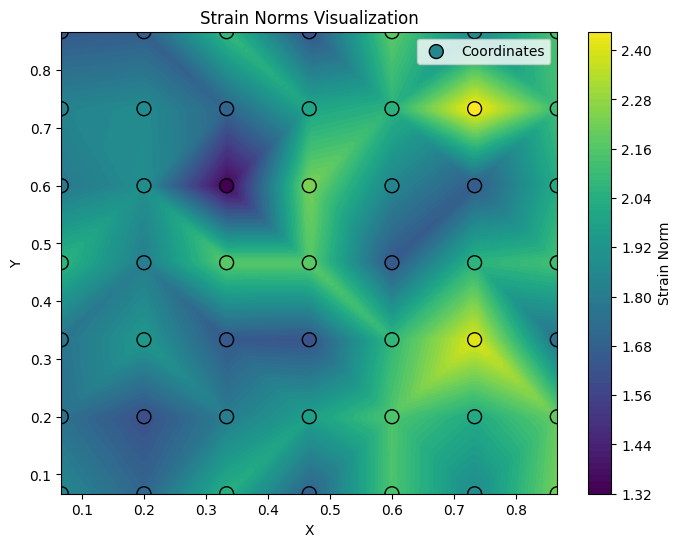

In [54]:
visualize_strain_norm_2D(rect_coordinates_001, rect_strain_norms_001)

(49,)


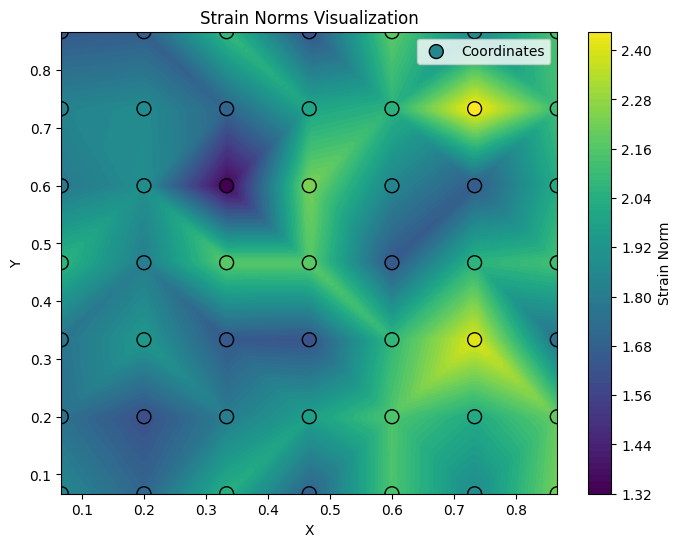

In [39]:
visualize_strain_norm_2D(rect_coordinates_001, rect_strain_norms_001)

In [56]:
rect_strain_matrices_05

array([[[1.33342  , 0.574678 ],
        [0.574678 , 1.00154  ]],

       [[1.37068  , 0.5809965],
        [0.5809965, 1.00506  ]],

       [[1.43504  , 0.5978855],
        [0.5978855, 0.99655  ]],

       [[1.48644  , 0.6127785],
        [0.6127785, 1.00219  ]],

       [[1.34534  , 0.567519 ],
        [0.567519 , 1.00362  ]],

       [[1.38603  , 0.578267 ],
        [0.578267 , 1.00652  ]],

       [[1.43796  , 0.588523 ],
        [0.588523 , 1.0016   ]],

       [[1.48129  , 0.604946 ],
        [0.604946 , 1.00085  ]],

       [[1.33577  , 0.5480395],
        [0.5480395, 1.00036  ]],

       [[1.39126  , 0.5572015],
        [0.5572015, 0.993302 ]],

       [[1.43974  , 0.5733755],
        [0.5733755, 0.999895 ]],

       [[1.48297  , 0.590324 ],
        [0.590324 , 0.996688 ]],

       [[1.32379  , 0.532224 ],
        [0.532224 , 1.00487  ]],

       [[1.3855   , 0.5400305],
        [0.5400305, 1.00009  ]],

       [[1.44523  , 0.5556905],
        [0.5556905, 1.00387  ]],

       [[1

### compare with ground truth 

In [61]:
import numpy as np

def deform_ground_truth(coords):
    x, y = coords
    x_out = 1.4 + 0.4 * x * x
    y_out = y
    return np.array([x_out, y_out])

def calculate_deformation_gradient(coords):
    x, y = coords
    df_dx = 0.8 * x 
    df_dy = 0  
    return np.array([[df_dx, df_dy], [df_dy, 1]])

def calculate_strain(coords):
    strain = []
    
    for point in coords:
        # Calculate the deformation gradient for each point
        F = calculate_deformation_gradient(point)
        
        # Calculate the strain tensor: E = 0.5 * (F + F.T - I)
        E = 0.5 * (F + F.T)
        strain.append(E)
    
    return np.array(strain)

def calculate_strain_norms(coords):
    strain_norms = []
    
    for point in coords:
        # Calculate the deformation gradient for each point
        F = calculate_deformation_gradient(point)
        
        # Calculate the strain tensor: E = 0.5 * (F + F.T - I)
        E = 0.5 * (F + F.T)
        
        # Calculate the Frobenius norm of the strain tensor
        strain_norm = np.linalg.norm(E)
        
        # Append the strain norm for the current point
        strain_norms.append(strain_norm)
    
    return np.array(strain_norms)

In [65]:
xy_values = [
    [0.333333, 0.333333],
    [0.466667, 0.333333],
    [0.6, 0.333333],
    [0.733333, 0.333333],
    [0.333333, 0.466667],
    [0.466667, 0.466667],
    [0.6, 0.466667],
    [0.733333, 0.466667],
    [0.333333, 0.6],
    [0.466667, 0.6],
    [0.6, 0.6],
    [0.733333, 0.6],
    [0.333333, 0.733333],
    [0.466667, 0.733333],
    [0.6, 0.733333],
    [0.733333, 0.733333]
]
xy_values = np.array(xy_values)
ground_truth_strain = calculate_strain(xy_values)
# np.savetxt( "../output/ground_truth_strain_rect.csv", ground_truth_strain.reshape(-1, 4), delimiter=",")
calculate_strain(xy_values)

array([[[0.2666664, 0.       ],
        [0.       , 1.       ]],

       [[0.3733336, 0.       ],
        [0.       , 1.       ]],

       [[0.48     , 0.       ],
        [0.       , 1.       ]],

       [[0.5866664, 0.       ],
        [0.       , 1.       ]],

       [[0.2666664, 0.       ],
        [0.       , 1.       ]],

       [[0.3733336, 0.       ],
        [0.       , 1.       ]],

       [[0.48     , 0.       ],
        [0.       , 1.       ]],

       [[0.5866664, 0.       ],
        [0.       , 1.       ]],

       [[0.2666664, 0.       ],
        [0.       , 1.       ]],

       [[0.3733336, 0.       ],
        [0.       , 1.       ]],

       [[0.48     , 0.       ],
        [0.       , 1.       ]],

       [[0.5866664, 0.       ],
        [0.       , 1.       ]],

       [[0.2666664, 0.       ],
        [0.       , 1.       ]],

       [[0.3733336, 0.       ],
        [0.       , 1.       ]],

       [[0.48     , 0.       ],
        [0.       , 1.       ]],

       [[0

In [68]:
np.linalg.norm(ground_truth_strain - rect_strain_matrices_05, 'fro',  axis=(1, 2))

array([1.34107241, 1.29222262, 1.2755577 , 1.24923669, 1.34450938,
       1.30168428, 1.26901874, 1.23784952, 1.32048371, 1.28730961,
       1.25643138, 1.22488202, 1.29771291, 1.26796952, 1.24469586,
       1.22081063])

### Ellipsoid visulization 